In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.constants import convert_temperature as conv_temp

from controllers import ControllerBase
from controllers import PIDController
from controllers import PIDController_T_top
from controllers import LQRControllerDisc
from controllers import LQRControllerCont
from controllers import MPCController
from classes import LEDparams, Model
from system import Simulation

from img import save_plot2pdf
from output_notebooks import save_bounds2csv

In [12]:
save_op_plot      = True
save_bound_values = True

save_sim_plots    = False

plot_sim_plots    = False

### Choose the controller here:
chosen_controller = 'PID'
# chosen_controller = 'LQR'

In [13]:
# PID
kp, ki, kd = -2.5, -4.0, 0.0
output_limits = (-3, 3)  # A

filename_pid = f"pid_kp_{kp:.1f}_ki_{ki:.1f}_kd_{kd:.1f}_lim_{output_limits[0]:.1f}_{output_limits[1]:.1f}"
filename_pid = filename_pid.replace(".0", "")
filename_pid = filename_pid.replace(".", "_")
print(filename_pid)

# LQR
q1 = 0
q2 = 25  # / (T_amb0**2)
q3 = 0
Q = np.array([[q1, 0, 0],
              [0, q2, 0],
              [0, 0, q3]])
r1 = 1
r2 = 1
R = np.array([[r1, 0],
              [0, r2]])

filename_lqr = f"lqr_q1_{q1:.1f}_q2_{q2:.1f}_q3_{q3:.1f}_r1_{r1:.1f}_r2_{r2:.1f}"
filename_lqr = filename_lqr.replace(".0", "")
filename_lqr = filename_lqr.replace(".", "_")
print(filename_lqr)

pid_kp_-2_5_ki_-4_kd_0_lim_-3_3
lqr_q1_0_q2_25_q3_0_r1_1_r2_1


In [14]:
### Parameters
# Simulation
dt_sim = 1.0 # s
time_span = 60.0 * 60 # s

assert time_span > 0, "Time span must be positive."
assert time_span >= dt_sim, "Time span must be greater than or equal to the time step."

# LED
LEDpar = LEDparams()

# Controller
dt_d = 2.0
T_cell_ref = conv_temp(37.0, 'C', 'K') # K

# Tracking
tracking_tol = 1 # °C or K
stop_cond_DT = 1 # K
max_iter = 10

# P_led_rad
num_P_rad = 11
P_rad_vec = np.linspace(0, 1, num_P_rad)

# Columns for the dataframes
columns = ['P_rad', 'DT', 'Tracking', 'T_amb', 'T_cell_ref']

### Lower Bound

In [15]:
# Initialize
current_DT = -20 # °C or K

lw_bound_df = pd.DataFrame(columns=columns)
lw_bound_df = lw_bound_df.astype({
    'P_rad': float,
    'DT': float,
    'Tracking': bool,
    'T_amb': float,
    'T_cell_ref': float
})

## Start simulation loop
lw_sim_results_list = []
lw_leg_titles = []
sim_num = 0
for P_rad_iter in range(num_P_rad):
    DT_step = 20 # °C or K
    DT_iter = 0
    prev_false_DT = None
    prev_true_DT = None

    while True:
        DT_iter = DT_iter + 1

        # First iterable variable
        x_LED_tot, I_LED, P_rad = LEDpar.get_x_from_P_rad(P_rad_vec[P_rad_iter])

        # Second iterable variable
        T_amb = T_cell_ref - current_DT

        # Initial conditions
        x0 = np.array([0.9,
                       T_amb,
                       T_amb])
        
        # Model
        model = Model(LEDpar, x0, T_amb0=T_amb)

        T_top_ref = T_amb + (T_cell_ref - T_amb) * (model.R_top_cell + model.R_cell_amb) / model.R_cell_amb

        if chosen_controller == 'PID':
            controller_sim = PIDController_T_top(kp=kp, ki=ki, kd=kd,
                                                       T_top_ref=T_top_ref, T_cell_ref=T_cell_ref,
                                                       sampling_time=dt_d, output_limits=output_limits)
        elif chosen_controller == 'LQR':
            Ad, Bd, hd, Cd, Dd, ld = model.get_discrete_linearization(T_ref=T_cell_ref, T_amb=T_amb, dt_d=dt_d)
            controller_sim = LQRControllerDisc(T_top_ref=T_top_ref, T_cell_ref=T_cell_ref, A_d=Ad, B_d=Bd, Q=Q, R=R, sampling_time=dt_d)
        else:
            raise ValueError("Invalid controller.")

        # Simulation
        sim = Simulation(model=model, controller=controller_sim, dt_sim=dt_sim, time_span=time_span)

        # Run the simulation
        results = sim.run(with_initial_time=False, initial_time_span=10)

        # Check tracking condition
        current_is_tracking = abs(results["T_cell"].iloc[-1] - T_cell_ref) <= tracking_tol and all(abs(results["T_top"] - results["T_bot"]) <= model.DeltaT_max)
        print(f"Current DT: {current_DT}, Current is tracking: {current_is_tracking}")

        
        results['tracked'] = current_is_tracking
        results['id_sim'] = sim_num
        results['P_rad']  = P_rad_iter
        results['DT']     = current_DT
        lw_sim_results_list.append(results)

        # Titles for legend and figures
        title_T_amb = r"$T_\mathrm{amb} =$" + f"{round(conv_temp(T_amb, 'K', 'C'))}°C"
        title_DT    = r"$\Delta T =$" + f"{current_DT:.1f}°C"
        title_P_rad = r"$P_\mathrm{led,rad} =$" + f"{P_rad:.2f}W"

        fig_title = chosen_controller + "     " + title_P_rad + "     " + title_DT + "     " + title_T_amb
        leg_title = title_P_rad + "," + title_T_amb

        lw_leg_titles.append(leg_title)

        # Plot sim results and name the file in case of saving
        if plot_sim_plots:
            filename = f"T_amb_{round(conv_temp(T_amb, 'K', 'C'))}" + "_" + f"P_rad_{P_rad:.1f}W"
            filename = filename.replace(".", "_")

            sim.plot_time_results(fig_title, save_plot=save_sim_plots, filename=filename)
            sim.plot_current_temperature(fig_title, save_plot=save_sim_plots, filename=filename)

        # Increase counter
        sim_num = sim_num + 1

        ### Grid search
        # Append data
        lw_bound_df = pd.concat([lw_bound_df, pd.DataFrame([[P_rad, current_DT, current_is_tracking, T_amb, T_cell_ref]], columns=columns)], ignore_index=True)

        # First call until both not None: found a tracking and not tracking solution
        if prev_false_DT is None and prev_true_DT is None:
            if current_is_tracking:
                prev_true_DT = current_DT
                current_DT = current_DT - DT_step # Go down
            else:
                prev_false_DT = current_DT
                current_DT = current_DT + DT_step # Go up

        # If previous is tracking
        elif prev_false_DT is None and prev_true_DT is not None:
            if current_is_tracking:
                prev_true_DT = current_DT
                current_DT = current_DT - DT_step # Go down
            else:
                prev_false_DT = current_DT
                # step size halving
                DT_step = DT_step / 2
                current_DT = (prev_true_DT + prev_false_DT) / 2

        # If previous is not tracking
        elif prev_false_DT is not None and prev_true_DT is None:
            if current_is_tracking:
                prev_true_DT = current_DT
                # step size halving
                DT_step = DT_step / 2
                current_DT = (prev_true_DT + prev_false_DT) / 2
            else:
                prev_false_DT = current_DT
                current_DT = current_DT + DT_step # Go up
        
        # If both not None
        else:
            if current_is_tracking:
                prev_true_DT = current_DT
            else:
                prev_false_DT = current_DT

            # step size halving
            DT_step = DT_step / 2
            current_DT = (prev_true_DT + prev_false_DT) / 2

        # Stop condition
        if abs(DT_step) <= stop_cond_DT or DT_iter >= max_iter:
            print("Stop condition reached.")
            break

# All results
lw_all_results_df = pd.concat(lw_sim_results_list).set_index(['id_sim', 'P_rad', 'DT', 'time'])

Current DT: -20, Current is tracking: True
Current DT: -40, Current is tracking: False
Current DT: -30.0, Current is tracking: True
Current DT: -35.0, Current is tracking: False
Current DT: -32.5, Current is tracking: True
Current DT: -33.75, Current is tracking: True
Stop condition reached.
Current DT: -34.375, Current is tracking: False
Current DT: -14.375, Current is tracking: True
Current DT: -24.375, Current is tracking: True
Current DT: -29.375, Current is tracking: False
Current DT: -26.875, Current is tracking: False
Current DT: -25.625, Current is tracking: False
Stop condition reached.
Current DT: -25.0, Current is tracking: False
Current DT: -5.0, Current is tracking: True
Current DT: -15.0, Current is tracking: True
Current DT: -20.0, Current is tracking: False
Current DT: -17.5, Current is tracking: False
Current DT: -16.25, Current is tracking: False
Stop condition reached.
Current DT: -15.625, Current is tracking: False
Current DT: 4.375, Current is tracking: True
Curren

### Upper Bound

In [16]:
# Initialize
current_DT = 30 # °C or K

up_bound_df = pd.DataFrame(columns=columns)
up_bound_df = up_bound_df.astype({
    'P_rad': float,
    'DT': float,
    'Tracking': bool,
    'T_amb': float,
    'T_cell_ref': float
})

## Start simulation loop
up_sim_results_list = []
up_leg_titles = []
# sim_num = 0
for P_rad_iter in range(num_P_rad):
    DT_step = 20 # °C or K
    DT_iter = 0
    prev_false_DT = None
    prev_true_DT = None

    while True:
        DT_iter = DT_iter + 1

        # First iterable variable
        x_LED_tot, I_LED, P_rad = LEDpar.get_x_from_P_rad(P_rad_vec[P_rad_iter])

        # Second iterable variable
        T_amb = T_cell_ref - current_DT

        # Initial conditions
        x0 = np.array([0.9,
                       T_amb,
                       T_amb])
        
        # Model
        model = Model(LEDpar, x0, T_amb0=T_amb)

        T_top_ref = T_amb + (T_cell_ref - T_amb) * (model.R_top_cell + model.R_cell_amb) / model.R_cell_amb

        if chosen_controller == 'PID':
            controller_sim = PIDController_T_top(kp=kp, ki=ki, kd=kd,
                                                       T_top_ref=T_top_ref, T_cell_ref=T_cell_ref,
                                                       sampling_time=dt_d, output_limits=output_limits)
        elif chosen_controller == 'LQR':
            Ad, Bd, hd, Cd, Dd, ld = model.get_discrete_linearization(T_ref=T_cell_ref, T_amb=T_amb, dt_d=dt_d)
            controller_sim = LQRControllerDisc(T_top_ref=T_top_ref, T_cell_ref=T_cell_ref, A_d=Ad, B_d=Bd, Q=Q, R=R, sampling_time=dt_d)
        else:
            raise ValueError("Invalid controller.")

        # Simulation
        sim = Simulation(model=model, controller=controller_sim, dt_sim=dt_sim, time_span=time_span)

        # Run the simulation
        results = sim.run(with_initial_time=False, initial_time_span=10)

        # Check tracking condition
        current_is_tracking = abs(results["T_cell"].iloc[-1] - T_cell_ref) <= tracking_tol and all(abs(results["T_top"] - results["T_bot"]) <= model.DeltaT_max)
        print(f"Current DT: {current_DT}, Current is tracking: {current_is_tracking}")

        
        results['tracked'] = current_is_tracking
        results['id_sim']  = sim_num
        results['P_rad']   = P_rad_iter
        results['DT']      = current_DT
        up_sim_results_list.append(results)

        # Titles for legend and figures
        title_T_amb = r"$T_\mathrm{amb} =$" + f"{round(conv_temp(T_amb, 'K', 'C'))}°C"
        title_DT    = r"$\Delta T =$" + f"{current_DT:.1f}°C"
        title_P_rad = r"$P_\mathrm{led,rad} =$" + f"{P_rad:.2f}W"

        fig_title = title_P_rad + "     " + title_DT + "     " + title_T_amb
        leg_title = title_P_rad + "," + title_T_amb

        up_leg_titles.append(leg_title)

        # Plot sim results and name the file in case of saving
        if plot_sim_plots:
            filename = f"T_amb_{round(conv_temp(T_amb, 'K', 'C'))}" + "_" + f"P_rad_{P_rad:.1f}W"
            filename = filename.replace(".", "_")

            sim.plot_time_results(fig_title, save_plot=save_sim_plots, filename=filename)
            sim.plot_current_temperature(fig_title, save_plot=save_sim_plots, filename=filename)

        # Increase counter
        sim_num = sim_num + 1

        ### Grid search
        # Append data
        up_bound_df = pd.concat([up_bound_df, pd.DataFrame([[P_rad, current_DT, current_is_tracking, T_amb, T_cell_ref]], columns=columns)], ignore_index=True)

        # First call until both not None: found a tracking and not tracking solution
        if prev_false_DT is None and prev_true_DT is None:
            if current_is_tracking:
                prev_true_DT = current_DT
                current_DT = current_DT + DT_step # Go up
            else:
                prev_false_DT = current_DT
                current_DT = current_DT - DT_step # Go down

        # If previous is tracking
        elif prev_false_DT is None and prev_true_DT is not None:
            if current_is_tracking:
                prev_true_DT = current_DT
                current_DT = current_DT + DT_step # Go up
            else:
                prev_false_DT = current_DT
                # step size halving
                DT_step = DT_step / 2
                current_DT = (prev_true_DT + prev_false_DT) / 2

        # If previous is not tracking
        elif prev_false_DT is not None and prev_true_DT is None:
            if current_is_tracking:
                prev_true_DT = current_DT
                # step size halving
                DT_step = DT_step / 2
                current_DT = (prev_true_DT + prev_false_DT) / 2
            else:
                prev_false_DT = current_DT
                current_DT = current_DT - DT_step # Go down
        
        # If both not None
        else:
            if current_is_tracking:
                prev_true_DT = current_DT
            else:
                prev_false_DT = current_DT

            # step size halving
            DT_step = DT_step / 2
            current_DT = (prev_true_DT + prev_false_DT) / 2

        # Stop condition
        if abs(DT_step) <= stop_cond_DT or DT_iter >= max_iter:
            print("Stop condition reached.")
            break

# All results
up_all_results_df = pd.concat(up_sim_results_list).set_index(['id_sim', 'P_rad', 'DT', 'time'])


Current DT: 30, Current is tracking: True
Current DT: 50, Current is tracking: True
Current DT: 70, Current is tracking: False
Current DT: 60.0, Current is tracking: False
Current DT: 55.0, Current is tracking: False
Current DT: 52.5, Current is tracking: False
Current DT: 51.25, Current is tracking: False
Stop condition reached.
Current DT: 50.625, Current is tracking: True
Current DT: 70.625, Current is tracking: False
Current DT: 60.625, Current is tracking: False
Current DT: 55.625, Current is tracking: True
Current DT: 58.125, Current is tracking: False
Current DT: 56.875, Current is tracking: False
Stop condition reached.
Current DT: 56.25, Current is tracking: True
Current DT: 76.25, Current is tracking: False
Current DT: 66.25, Current is tracking: False
Current DT: 61.25, Current is tracking: True
Current DT: 63.75, Current is tracking: False
Current DT: 62.5, Current is tracking: False
Stop condition reached.
Current DT: 61.875, Current is tracking: True
Current DT: 81.875, C

In [17]:
### LOWER BOUND
# Filter for tracked points
lw_tracked_points     = lw_bound_df[lw_bound_df['Tracking'] == True]
lw_not_tracked_points = lw_bound_df[lw_bound_df['Tracking'] == False]

# Group by P_rad and select the minimum DT for each group
min_tracked_points = lw_tracked_points.groupby('P_rad', as_index=False)['DT'].min()

# Extract x (P_rad) and y (DT) for minimum tracked points
lw_x = min_tracked_points['P_rad'].values
lw_y = min_tracked_points['DT'].values

# Construct the design matrix X with exponential features
lw_X = np.vstack([np.ones_like(lw_x), lw_x, np.exp(lw_x)]).T

# Compute theta using the normal equation
lw_theta = np.linalg.inv(lw_X.T @ lw_X) @ lw_X.T @ lw_y

def lower_bound(x):
    return lw_theta[0] + lw_theta[1] * x + lw_theta[2] * np.exp(x)

### UPPER BOUND
# Filter for tracked points
up_tracked_points     = up_bound_df[up_bound_df['Tracking'] == True]
up_not_tracked_points = up_bound_df[up_bound_df['Tracking'] == False]

# Group by P_rad and select the maximum DT for each group
max_tracked_points = up_tracked_points.groupby('P_rad', as_index=False)['DT'].max()

# Extract x (P_rad) and y (DT) for maximum tracked points
up_x = max_tracked_points['P_rad'].values
up_y = max_tracked_points['DT'].values

# Construct the design matrix X with exponential features
up_X = np.vstack([np.ones_like(up_x), up_x, np.exp(up_x)]).T

# Compute theta using the normal equation
up_theta = np.linalg.inv(up_X.T @ up_X) @ up_X.T @ up_y

def upper_bound(x):
    return up_theta[0] + up_theta[1] * x + up_theta[2] * np.exp(x)


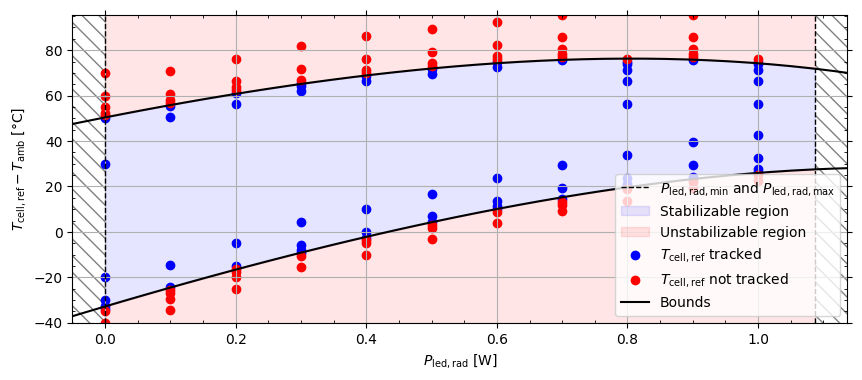

In [18]:

### Plotting
x_limits = [min(P_rad_vec)-0.05,    LEDpar.P_rad_max+0.05]
y_limits = [min(lw_bound_df['DT']), max(up_bound_df['DT'])]

x_line = np.linspace(-1, 2*LEDpar.P_rad_max, 100)
lw_y_line = lower_bound(x_line)
up_y_line = upper_bound(x_line)

x_line_feas = np.linspace(0, LEDpar.P_rad_max, len(x_line))
lw_y_line_feas = lower_bound(x_line_feas)
up_y_line_feas = upper_bound(x_line_feas)

# T_amb_vec = np.linspace(17, 57, 3) # °C
# T_ref_vec = np.linspace(17, 57, 3) # °C
# other_var_vec = np.linspace(-80, 80, len(x_line))

# Figure
fig, ax = plt.subplots(figsize=(10, 4))
# ax.axhline(y=0, lw=1, color='black', label='_nolegend_')
# ax.axvline(x=0, lw=1, color='black', label='_nolegend_')

# Constraints
fill_color = 'gray'
fill_alpha = 0.1
hatch_style = '\\\\'

ax.axvline(x=min(P_rad_vec), lw=1, color='black', linestyle='--', label=r'$P_\mathrm{led,rad,min}$ and $P_\mathrm{led,rad,max}$')
ax.axvline(x=LEDpar.P_rad_max, lw=1, color='black', linestyle='--', label='_nolegend_')

# ax.fill_betweenx(y_limits, x_limits[0], min(P_rad_vec), color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_betweenx(y_limits, x_limits[0], min(P_rad_vec), color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')
# ax.fill_betweenx(y_limits, LEDpar.P_rad_max, 2, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_betweenx(y_limits, LEDpar.P_rad_max, 2, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

ax.fill_between(x_line_feas, lw_y_line_feas, up_y_line_feas, color='blue', alpha=0.1, label='Stabilizable region')

ax.fill_between(x_line_feas, lw_y_line_feas, -50, color='red', alpha=0.1, label='Unstabilizable region')
ax.fill_between(x_line_feas, up_y_line_feas, 150, color='red', alpha=0.1, label='_nolegend_')

ax.scatter(lw_tracked_points['P_rad'], lw_tracked_points['DT'], color='blue', label=r'$T_\mathrm{cell,ref}$ tracked')
ax.scatter(lw_not_tracked_points['P_rad'], lw_not_tracked_points['DT'], color='red', label=r'$T_\mathrm{cell,ref}$ not tracked')
ax.scatter(up_tracked_points['P_rad'], up_tracked_points['DT'], color='blue', label='_nolegend_')
ax.scatter(up_not_tracked_points['P_rad'], up_not_tracked_points['DT'], color='red', label='_nolegend_')

# # Constant line
# for T_amb in T_amb_vec:
#     ax.plot(x_line, other_var_vec - T_amb, color='black', linestyle='--', label='_nolegend_')

ax.plot(x_line, lw_y_line, color='black', label='Bounds')
ax.plot(x_line, up_y_line, color='black', label='_nolegend_')

ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r'$P_\mathrm{led,rad}$ [W]')
ax.set_ylabel(r'$T_\mathrm{cell,ref} - T_\mathrm{amb}$ [°C]')
# ax.set_title('Operational Space')
# ax.legend()
ax.legend(loc = 'lower right')
ax.grid()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(axis='x', which='minor', direction='in', top=True)
ax.tick_params(axis='y', which='minor', direction='in', left=True, right=True)
ax.tick_params(axis='x', which='major', top=True)
ax.tick_params(axis='y', which='major', left=True, right=True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

if save_op_plot:
    # Generate filename dynamically
    filename = f"op_space_{filename_pid}" if chosen_controller == 'PID' else f"op_space_{filename_lqr}"
    save_plot2pdf(filename, fig)
plt.show()

# Save theta values
if save_bound_values:
    # Generate filename dynamically
    filename = f"bounds_{filename_pid}.csv" if chosen_controller == 'PID' else f"bounds_{filename_lqr}.csv"

    # Create a DataFrame with descriptive headers
    theta_data = pd.DataFrame({
        "Bound": ["Upper", "Lower"],
        "Theta_0": [up_theta[0], lw_theta[0]],
        "Theta_1": [up_theta[1], lw_theta[1]],
        "Theta_2": [up_theta[2], lw_theta[2]]
    })

    # Save the DataFrame to a CSV file
    save_bounds2csv(theta_data, filename)